# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

    
<li>*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</li>
<li>*Предложите свои варианты решения проблемы исчезающего градиента в RNN</li>
</ol>

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
#from sklearn.preprocessing import MinMaxScaler
from __future__ import print_function

In [3]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

In [4]:
stock_full = pd.read_csv('BRK-A.csv') # stock Berkshire Hathaway Inc. (BRK-A) 
# https://finance.yahoo.com/quote/BRK-A/history?period1=1490832000&period2=1648598400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
stock_full.shape

(1260, 7)

In [5]:
def data_preparation(df, train_days=60, scaling=False, min_val=0, max_val=1):
    # will be used just open market(column open)
    df_processed = df.iloc[:, 1:2].values
    
    if scaling:
        df_scaled = (df_processed - min_val) / (max_val - min_val)
        df_processed = df_scaled * (1 - 0.001) + 0.001
        
    features_set = []
    labels = []
    for i in range(train_days, df.shape[0]):
        features_set.append(df_processed[i-train_days:i, 0])
        labels.append(df_processed[i, 0])

    features_set, labels = np.array(features_set), np.array(labels)
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
    return features_set, labels

In [6]:
#number of days for predictions(train test split)
predict_days = 40 # 3 months
#number of days for training
train_days = 90
stock_train = stock_full[:-predict_days]

In [7]:
features_set, labels = data_preparation(stock_train, train_days, True, stock_train.iloc[:,1:2].values.min(), stock_train.iloc[:,1:2].values.max())

In [8]:
model = Sequential()

2022-03-30 18:10:55.035108: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
#NotImplementedError: Cannot convert a symbolic Tensor (lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
#conda install -c conda-forge numpy=1.19

In [10]:
#conda install numpy==1.19.2 

In [11]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_days, 1)))

In [12]:
#to avoid retraining
model.add(Dropout(0.1))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=50))
model.add(Dropout(0.1))

model.add(Dense(units = 1))

In [13]:
model.compile(optimizer = 'adam', loss = 'mean_absolute_percentage_error') 
#'mean_absolute_error' #'mean_squared_error'

In [14]:
model.fit(features_set, labels, epochs = 100, batch_size = 32)

2022-03-30 18:10:56.098208: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
36/36 [==============================] - 16s 277ms/step - loss: 44.2631
Epoch 2/100
36/36 [==============================] - 7s 198ms/step - loss: 19.6915
Epoch 3/100
36/36 [==============================] - 7s 187ms/step - loss: 17.9467
Epoch 4/100
36/36 [==============================] - 7s 206ms/step - loss: 16.3816
Epoch 5/100
36/36 [==============================] - 7s 190ms/step - loss: 15.5710
Epoch 6/100
36/36 [==============================] - 8s 208ms/step - loss: 14.0487
Epoch 7/100
36/36 [==============================] - 8s 211ms/step - loss: 13.4715
Epoch 8/100
36/36 [==============================] - 8s 237ms/step - loss: 13.9407
Epoch 9/100
36/36 [==============================] - 6s 179ms/step - loss: 13.3935
Epoch 10/100
36/36 [==============================] - 7s 185ms/step - loss: 13.5649
Epoch 11/100
36/36 [==============================] - 6s 176ms/step - loss: 12.4299
Epoch 12/100
36/36 [==============================] - 7s 189ms/step - loss: 10.6759


36/36 [==============================] - 7s 192ms/step - loss: 6.6479
Epoch 100/100
36/36 [==============================] - 7s 192ms/step - loss: 6.6959


In [15]:
# test data preparation - additional train_days to predict data for all predict_days
stock_test = stock_full[-(predict_days+train_days):]

In [16]:
features_set_test, labels_test = data_preparation(stock_test, train_days,  True, stock_train.iloc[:,1:2].values.min(), stock_train.iloc[:,1:2].values.max())

In [17]:
features_set_test.shape, predict_days, train_days, features_set.shape, stock_test.shape

((40, 90, 1), 40, 90, (1130, 90, 1), (130, 7))

In [18]:
predictions = (model.predict(features_set_test)-0.001)/(1 - 0.001)*(stock_train.iloc[:,1:2].values.max()-stock_train.iloc[:,1:2].values.min()) + stock_train.iloc[:,1:2].values.min()

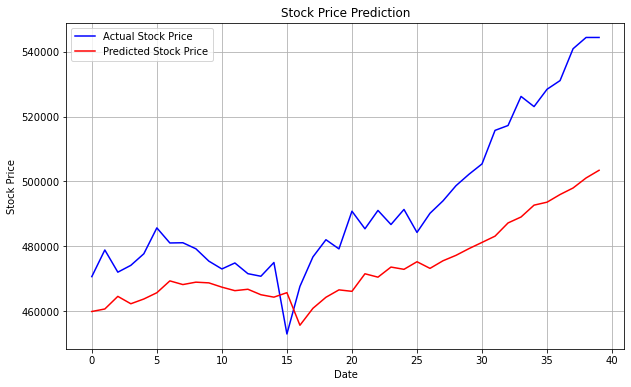

In [20]:
plt.figure(figsize=(10,6))
plt.plot(stock_test.iloc[-predict_days:,1:2].values, color='blue', label='Actual Stock Price')
plt.plot(predictions , color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## Дополнительные материалы

<ol>
    <li>Оригинальная научная статья по LSTM - https://www.bioinf.jku.at/publications/older/2604.pdf</li>
    <li>Оригинальная научная статья по GRU - https://arxiv.org/abs/1406.1078</li>
</ol>

## Используемая литература 

Для подготовки данного методического пособия были использованы следующие ресурсы:
<ol>
    <li>https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru</li>
    <li>Шакла Н. — Машинное обучение и TensorFlow 2019</li>
    <li>Николенко, Кадурин, Архангельская: Глубокое обучение. Погружение в мир нейронных сетей 2018</li>
    <li>Aurélien Géron - Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2019</li>
    <li>https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21</li>
    <li>https://github.com/llSourcell/recurrent_neural_net_demo</li>
    
</ol>